In [2]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [4]:
df = pd.read_csv('twt_#ifc.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['full_text', 'sent_score']]
df.head()

,full_text,sent_score
1058,shreemanth dagdusheth halwai ganpati mandal pr...,1
934,protect extrem poverti deadli diseas covid bey...,-1
1162,It two month sinc odisha start war covid singl...,1
1581,incred gener articl research follow covid stud...,-1
1393,where china foreign ministri stoog took social...,-1


In [5]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.full_text.apply(remove_stopwords).apply(remove_mentions)
df.head()

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


,full_text,sent_score
1058,shreemanth dagdusheth halwai ganpati mandal pr...,1
934,protect extrem poverti deadli diseas covid bey...,-1
1162,It two month sinc odisha start war covid singl...,1
1581,incred gener articl research follow covid stud...,-1
1393,where china foreign ministri stoog took social...,-1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.full_text, df.sent_score, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 1574
# Test data samples: 175


In [8]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are: \n \n', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 1574 documents
10000 words in dictionary
Top 5 most common words are: 
 
 [('covid', 851), ('lockdown', 606), ('indiafightscorona', 306), ('amp', 176), ('india', 171)]


In [9]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('\n "{}" is converted into \n \n {}'.format(X_train[0], X_train_seq[0]))


 "whi wait get fine govern take care wear mask maintain social distanc facemask lockdow" is converted into 
 
 [523, 524, 48, 1, 6, 28, 6, 26, 118, 27, 105, 525, 8, 6, 26, 118, 954, 1487, 1488, 1489, 2181, 1490, 2182, 2183, 2184]


In [10]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('\n" {}" is converted into\n\n{}'.format(X_train_seq[0], X_train_oh[0]))
print('\n For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))


" [523, 524, 48, 1, 6, 28, 6, 26, 118, 27, 105, 525, 8, 6, 26, 118, 954, 1487, 1488, 1489, 2181, 1490, 2182, 2183, 2184]" is converted into

[0. 1. 0. ... 0. 0. 0.]

 For this example we have 21.0 features with a value of 1.


In [11]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"-1" is converted into 2
"2" is converted into [0. 0. 1.]


In [12]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (158, 10000)


In [13]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [14]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [15]:
base_history = deep_model(base_model)


In [16]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

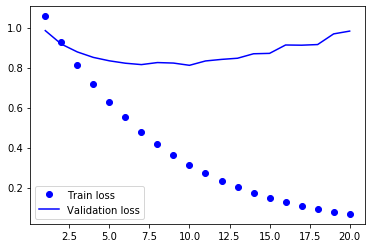

In [18]:
eval_metric(base_history, 'loss')


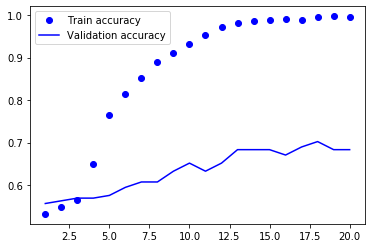

In [19]:
eval_metric(base_history, 'accuracy')


In [20]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [21]:
reduced_history = deep_model(reduced_model)


In [28]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

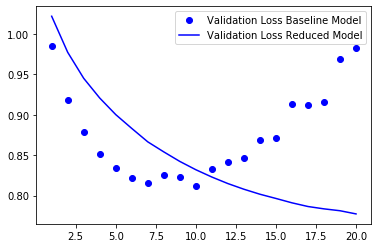

In [29]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')


In [30]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [31]:
reg_history = deep_model(reg_model)


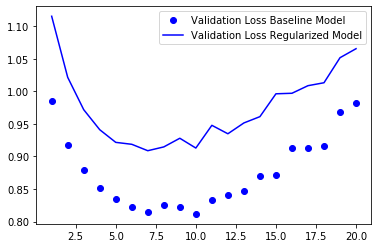

In [32]:
compare_loss_with_baseline(reg_history, 'Regularized Model')


In [33]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [34]:
drop_history = deep_model(drop_model)


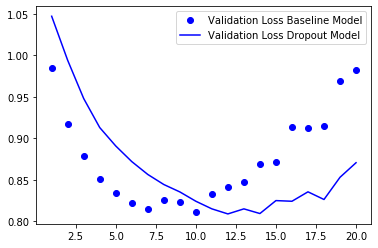

In [35]:
compare_loss_with_baseline(drop_history, 'Dropout Model')


In [36]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [45]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

175/175 [==============================] - 0s 222us/step
/n
Test accuracy of baseline model: 62.86%


In [46]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

175/175 [==============================] - 0s 199us/step
/n
Test accuracy of reduced model: 65.71%


In [47]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

175/175 [==============================] - 0s 256us/step
/n
Test accuracy of regularized model: 66.86%


In [48]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

175/175 [==============================] - 0s 223us/step
/n
Test accuracy of dropout model: 67.43%


In [53]:
https://www.kaggle.com/bertcarremans/deep-learning-for-sentiment-analysis

SyntaxError: invalid syntax (<ipython-input-53-b33d2a890f71>, line 1)